# TSP - Traveling Salesman Problem

[TSP](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce), Traveling Salesman Problem ou Problème du Voyageur de Commerce est un problème classique. Il s'agit de trouver le plus court chemin passant par des villes en supposant qu'il existe une route entre chaque paire de villes.

In [1]:
%matplotlib inline

## Enoncé

On part d'un ensemble de villes aléatoires.

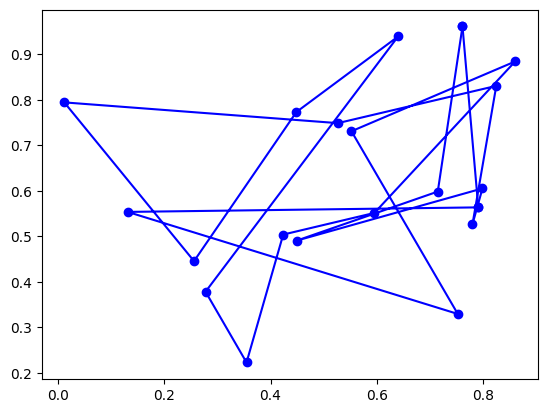

In [2]:
import numpy
import matplotlib.pyplot as plt

villes = numpy.random.rand(20, 2)
plt.plot(villes[:, 0], villes[:, 1], "b-o")
plt.plot([villes[0, 0], villes[-1, 0]], [villes[0, 1], villes[-1, 1]], "b-o");

### Q1 : choisir une permutation aléatoire des villes et calculer la distance du chemin qui les relie dans cet ordre


### Q2 : tirer deux villes aléatoirement, les inverser, garder la permutation si elle améliore la distance

### Q3 : choisir deux villes aléatoirement, permuter une des deux moitiés...

### Q4 : tester toutes les permutations possibles... je plaisante...

Choisir les deux villes les plus proches, les relier, recommencer, puis... vous trouverez bien quelque chose pour finir.

## Réponses

### Q1

On redessine le parcours entre les villes. 

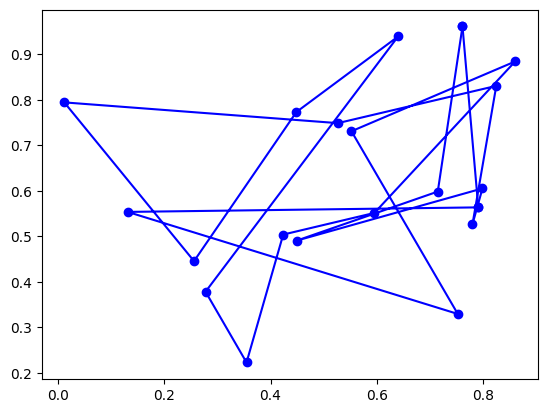

In [3]:
plt.plot(villes[:, 0], villes[:, 1], "b-o")
plt.plot([villes[0, 0], villes[-1, 0]], [villes[0, 1], villes[-1, 1]], "b-o");

La première étape consiste à calculer la distance d'un chemin passant par toutes les villes.

In [4]:
def distance_ville(v1, v2):
    return numpy.sum((v1 - v2) ** 2) ** 0.5


def distance_tour(villes, permutation):
    tour = distance_ville(villes[permutation[0]], villes[permutation[-1]])
    for i in range(0, len(permutation) - 1):
        tour += distance_ville(villes[permutation[i]], villes[permutation[i + 1]])
    return tour


distance_tour(villes, list(range(villes.shape[0])))

7.540451130306862

Ensuite, pour voir la solution, on insère le code qui permet de dessiner le chemin dans une fonction.

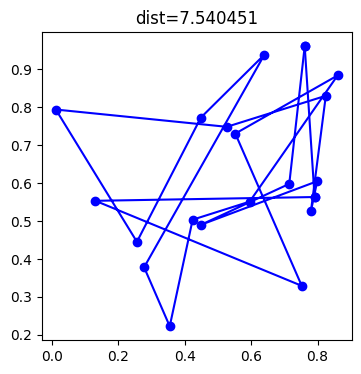

In [5]:
def dessine_tour(villes, perm):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.plot(villes[perm, 0], villes[perm, 1], "b-o")
    ax.plot(
        [villes[perm[0], 0], villes[perm[-1], 0]],
        [villes[perm[0], 1], villes[perm[-1], 1]],
        "b-o",
    )
    ax.set_title("dist=%f" % distance_tour(villes, perm))
    return ax


perm = list(range(villes.shape[0]))
dessine_tour(villes, perm);

### Q2

On rédige l'algorithme.

nb perm 8


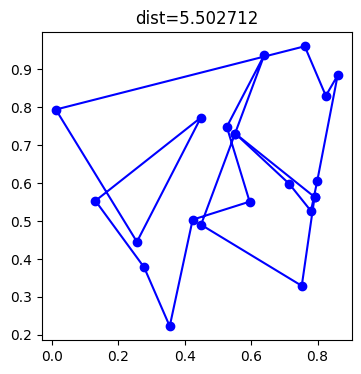

In [6]:
def ameliore_tour(villes, perm=None):
    # On copie la permutation perm pour éviter de modifier celle
    # transmise à la fonction. Si la permutation est vide,
    # on lui affecte la permutation identique.
    perm = perm.copy() if perm is not None else list(range(villes.shape[0]))
    # On calcule la distance actuelle.
    dist_min = distance_tour(villes, perm)
    # Initialisation.
    cont = True
    nb_perm, nb_iter = 0, 0
    # Tant que la distance n'est pas améliorée dans les dernières
    # len(perm) itérations.
    while cont or nb_iter < len(perm):
        nb_iter += 1
        # On tire deux villes au hasard.
        a = numpy.random.randint(0, len(perm) - 2)
        b = numpy.random.randint(a + 1, len(perm) - 1)
        # On permute les villes.
        perm[a], perm[b] = perm[b], perm[a]
        # On calcule la nouvelle distance.
        dist = distance_tour(villes, perm)
        # Si elle est meilleure...
        if dist < dist_min:
            # On la garde.
            dist_min = dist
            cont = True
            nb_perm += 1
            nb_iter = 0
        else:
            # Sinon, on annule la modification.
            perm[a], perm[b] = perm[b], perm[a]
            cont = False
    return dist_min, nb_perm, perm


dist, nb_perm, perm = ameliore_tour(villes)
print("nb perm", nb_perm)
dessine_tour(villes, perm);

C'est pas extraordinaire.

### Q3

Lorsque deux segments du chemin se croisent, il est possible de construire un autre chemin plus court en *retournant* une partie du chemin.

nb perm 26


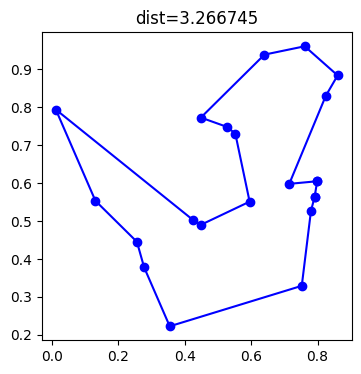

In [7]:
def ameliore_tour_renversement(villes, perm=None):
    perm = perm.copy() if perm is not None else list(range(villes.shape[0]))
    dist_min = distance_tour(villes, perm)
    cont = True
    nb_perm, nb_iter = 0, 0
    while cont or nb_iter < len(perm) ** 2:
        nb_iter += 1
        # Une partie qui change. On fait une copie de la permutation.
        p0 = perm.copy()
        a = numpy.random.randint(0, len(perm) - 2)
        b = numpy.random.randint(a + 1, len(perm) - 1)
        # On retourne une partie de cette permutation.
        if a == 0:
            perm[0:b] = perm[b:0:-1]
            perm[b] = p0[0]
        else:
            perm[a : b + 1] = perm[b : a - 1 : -1]
        # La suite est quasi-identique.
        dist = distance_tour(villes, perm)
        if dist < dist_min:
            dist_min = dist
            cont = True
            nb_perm += 1
            nb_iter = 0
        else:
            # On reprend la copie. C'est plus simple
            # que de faire le retournement inverse.
            perm = p0
            cont = False
    return dist_min, nb_perm, perm


dist, nb_perm, perm = ameliore_tour_renversement(villes)
print("nb perm", nb_perm)
dessine_tour(villes, perm);

Il n'y a plus de croisements, ce qui est l'effet recherché.

### Q4

On pourrait combiner ces deux fonctions pour améliorer l'algorithme qui resterait sans doute très long pour un grand nombre de villes. On pourrait initialiser l'algorithme avec une permutation moins aléatoire pour accélérer la convergence. Pour ce faire, on regroupe les deux villes les plus proches, puis de proche en proche...

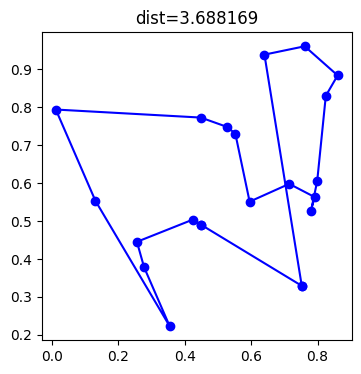

In [8]:
from scipy.spatial.distance import cdist


def build_permutation(villes):
    pairs = cdist(villes, villes)
    max_dist = pairs.ravel().max()
    for i in range(villes.shape[0]):
        pairs[i, i] = max_dist
    arg = numpy.argmin(pairs, axis=1)
    arg_dist = [(pairs[i, arg[i]], i, arg[i]) for i in range(villes.shape[0])]
    mn = min(arg_dist)
    perm = list(mn[1:])
    pairs[perm[0], :] = max_dist
    pairs[:, perm[0]] = max_dist
    while len(perm) < villes.shape[0]:
        last = perm[-1]
        arg = numpy.argmin(pairs[last : last + 1])
        perm.append(arg)
        pairs[perm[-2], :] = max_dist
        pairs[:, perm[-2]] = max_dist
    return perm


perm = build_permutation(villes)
dessine_tour(villes, perm);

Pas si mal... Il reste un croisement. On applique la fonction de la question précédente.

nb perm 8


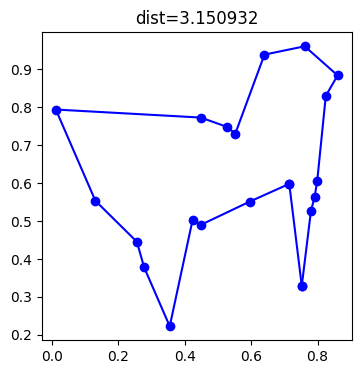

In [9]:
dist, nb_perm, perm = ameliore_tour_renversement(villes, perm)
print("nb perm", nb_perm)
dessine_tour(villes, perm);

Ce n'est pas nécessairement le meilleur chemin mais ça va plus vite.